## This python notebook plots up bottom & 100m mean temperature from the CESM2-LE for antarctic SIZ

In [2]:
import intake
import matplotlib.pyplot as plt
import xarray as xr
from distributed import Client
from ncar_jobqueue import NCARCluster
import dask
import numpy as np
from dask_jobqueue import PBSCluster
import warnings
warnings.filterwarnings('ignore')
import pop_tools
from glob import glob
import utils
import cartopy
import cartopy.crs as ccrs
import matplotlib.path as mpath
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors

In [3]:
ds_grid = pop_tools.get_grid('POP_gx1v7').isel(nlat=slice(0,55))
lats = ds_grid.TLAT
lons = ds_grid.TLONG
area = ds_grid.TAREA
lons_norm = utils.normal_lons(lons)

### Get some DASK going to speed up processing

In [4]:
# Setup your PBSCluster
cluster = PBSCluster(
    cores=2, # The number of cores you want
    memory='25 GB', # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    resource_spec='select=1:ncpus=2:mem=25GB', # Specify resources
    project='NCGD0011', # Input your project ID here
    walltime='03:00:00', # Amount of wall time
    interface='ext', # Interface to use
)
# Scale up
cluster.scale(12)

# Change your url to the dask dashboard so you can see it
dask.config.set({'distributed.dashboard.link':'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'})

# Setup your client
client = Client(cluster)

In [5]:
client

Client Scheduler: tcp://128.117.208.178:46051 Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kristenk/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


### Grab pre-processed ocean temp on bottom temperature

In [6]:
def preprocess(ds):
    ds = ds.isel(nlat=slice(0,55))
    return ds

In [7]:
%%time
files = sorted(glob(f'/glade/campaign/cesm/development/bgcwg/projects/CESM2-LE-FEISTY/drivers/TEMP_bottom/CESM2-LE_HIST_SSP370_TEMP_bottom_????????.nc'))       
ds = xr.open_mfdataset(files, concat_dim="member_id", combine='nested',preprocess=preprocess).compute()

CPU times: user 6.97 s, sys: 17.9 s, total: 24.9 s
Wall time: 2min 9s


In [8]:
%%time
files = sorted(glob(f'/glade/campaign/cesm/development/bgcwg/projects/CESM2-LE-FEISTY/drivers/TEMP_100m/CESM2-LE_HIST_SSP370_TEMP_mean_100m_????????.nc'))       
ds_tmp = xr.open_mfdataset(files, concat_dim="member_id", combine='nested',preprocess=preprocess).compute()

CPU times: user 5.81 s, sys: 15 s, total: 20.8 s
Wall time: 1min 18s


In [9]:
ds['TEMP_100m'] = ds_tmp.TEMP

### Make annual means

In [10]:
%%time

ds = ds.resample({'time':'A'}).mean(dim='time').compute()

CPU times: user 19.9 s, sys: 18.6 s, total: 38.5 s
Wall time: 2min 41s


In [11]:
ds['time'] = np.arange(1850,2101,1)

In [12]:
ds = ds.isel(time=slice(70,250))

In [13]:
ds

<xarray.Dataset>
Dimensions:      (member_id: 50, nlat: 55, nlon: 320, time: 180)
Coordinates:
  * time         (time) int64 1920 1921 1922 1923 1924 ... 2096 2097 2098 2099
    TLAT         (nlat, nlon) float64 -79.22 -79.22 -79.22 ... -50.37 -50.37
    TLONG        (nlat, nlon) float64 320.6 321.7 322.8 ... 317.2 318.3 319.4
  * member_id    (member_id) <U8 '1001.001' '1021.002' ... '1301.009' '1301.010'
Dimensions without coordinates: nlat, nlon
Data variables:
    TEMP_bottom  (time, member_id, nlat, nlon) float32 nan nan ... 2.214 1.908
    HT           (time, member_id, nlat, nlon) float64 0.0 0.0 ... 2.53e+05
    KMT          (time, member_id, nlat, nlon) float64 0.0 0.0 0.0 ... 45.0 48.0
    TEMP_100m    (time, member_id, nlat, nlon) float32 nan nan ... 6.549 6.588

### ToE calculation

In [14]:
time3d = np.full([180,55,320],1,dtype=int)

ylen = 55
xlen = 320

for x in np.arange(0,xlen,1):
    for y in np.arange(0,ylen,1):

        time3d[:,y,x]=ds.time.values

time3d = xr.DataArray(time3d,dims=('time','nlat','nlon'))

In [15]:
%%time

# #### empty dictionaries, keys are variable names
upthres_ds = xr.Dataset()
lothres_ds = xr.Dataset()

variables=['TEMP_bottom','TEMP_100m']

for var in variables:
    
    ### calculate                                                                                                                                                                                                                                                                 
    mean_var = ds[var].isel(time=slice(0,30)).mean(dim=('time','member_id'))
    std_var = ds[var].isel(time=slice(0,30)).std(dim=('member_id','time'))
    
    var_array_upthres = mean_var + 2 * std_var
    var_array_lothres = mean_var - 2 * std_var

    upthres_ds[var] = var_array_upthres
    lothres_ds[var] = var_array_lothres

CPU times: user 202 ms, sys: 39.1 ms, total: 241 ms
Wall time: 246 ms


In [16]:
ToE_down_TEMP_100m = time3d.where(ds.TEMP_100m.mean(dim='member_id') < lothres_ds['TEMP_100m'])
ToE_down_TEMP_100m = ToE_down_TEMP_100m.min(dim='time')

ToE_down_TEMP_bottom = time3d.where(ds.TEMP_bottom.mean(dim='member_id') < lothres_ds['TEMP_bottom'])
ToE_down_TEMP_bottom = ToE_down_TEMP_bottom.min(dim='time')

In [17]:
ToE_up_TEMP_100m = time3d.where(ds.TEMP_100m.mean(dim='member_id') > upthres_ds['TEMP_100m'])
ToE_up_TEMP_100m = ToE_up_TEMP_100m.min(dim='time')

ToE_up_TEMP_bottom = time3d.where(ds.TEMP_bottom.mean(dim='member_id') > upthres_ds['TEMP_bottom'])
ToE_up_TEMP_bottom = ToE_up_TEMP_bottom.min(dim='time')

In [18]:
ds_siz_mask = xr.open_dataset('/glade/u/home/kristenk/antarc_marine_pred_work/TOE/SIZ_mask_1920-50-CESM2LE_15percentJJA.nc')
ds_siz_mask = ds_siz_mask.isel(nlat=slice(0,55))
ds_siz_mask

<xarray.Dataset>
Dimensions:  (nlat: 55, nlon: 320)
Coordinates:
    TLONG    (nlat, nlon) float64 ...
    TLAT     (nlat, nlon) float64 ...
Dimensions without coordinates: nlat, nlon
Data variables:
    SIZ      (nlat, nlon) float64 ...

In [19]:
#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)


### Maps of ToE

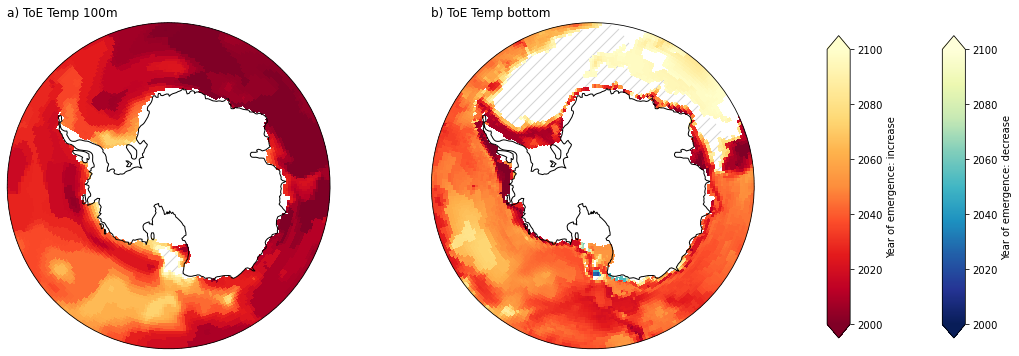

In [20]:
fig = plt.figure(figsize=(16,6))

#########################################################
ax = fig.add_subplot(1,2,1, projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -57], ccrs.PlateCarree())
ax.set_title('a) ToE Temp 100m', loc='left')

### add hatch lines for the SIZ
plt.rcParams['hatch.color'] = 'lightgray'
lon, lat, field = utils.adjust_pop_grid(lons, lats, ds_siz_mask.SIZ)
pci=ax.contourf(lon, lat, field,transform=ccrs.PlateCarree(),hatches=['//'],colors='none')


lon,lat,field = utils.adjust_pop_grid(lons, lats, ToE_up_TEMP_100m)

pc1 = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                   cmap='YlOrRd_r',
                   vmin=2000,vmax=2100
                  )

lon,lat,field = utils.adjust_pop_grid(lons, lats, ToE_down_TEMP_100m)

pc2 = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                   cmap='YlGnBu_r',
                   vmin=2000,vmax=2100
                  )
ax.set_boundary(circle, transform=ax.transAxes)

ax.coastlines('110m',linewidth=1)

######## ToE NPP increase #################################################
ax = fig.add_subplot(1,2,2, projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -57], ccrs.PlateCarree())
ax.set_title('b) ToE Temp bottom', loc='left')

### add hatch lines for the SIZ
plt.rcParams['hatch.color'] = 'lightgray'
lon, lat, field = utils.adjust_pop_grid(lons, lats, ds_siz_mask.SIZ)
pci=ax.contourf(lon, lat, field,transform=ccrs.PlateCarree(),hatches=['//'],colors='none')

lon,lat,field = utils.adjust_pop_grid(lons, lats, ToE_up_TEMP_bottom)

pc1 = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                   cmap='YlOrRd_r',
                   vmin=2000,vmax=2100
                  )

lon,lat,field = utils.adjust_pop_grid(lons, lats, ToE_down_TEMP_bottom)

pc2 = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                   cmap='YlGnBu_r',
                   vmin=2000,vmax=2100
                  )

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

ax.coastlines('110m',linewidth=1)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar1 = fig.colorbar(pc1, cax=cbar_ax,extend='both',label='Year of emergence: increase')


cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
cbar1 = fig.colorbar(pc2, cax=cbar_ax,extend='both',label='Year of emergence: decrease')
#fig.savefig('/glade/work/kristenk/figs/fig_TOE_Krill_growth_pot.png', bbox_inches='tight', dpi=300, format='png');

### Read in masks around Antarctic

In [21]:
ts_siz = xr.Dataset()

for v in ['TEMP_bottom','TEMP_100m']:


    masked_area = area.where(ds_siz_mask['SIZ']==1)
    
    masked_var = ds[v].where(ds_siz_mask['SIZ']==1)
    masked_area['nlat'] = ds_siz_mask['SIZ'].nlat
    masked_area['nlon'] = ds_siz_mask['SIZ'].nlon
    
    ts_siz[v] = (masked_var * masked_area).sum(dim=('nlon','nlat')) / masked_area.sum(dim=('nlon','nlat'))
        

In [22]:
years = ts_siz.time

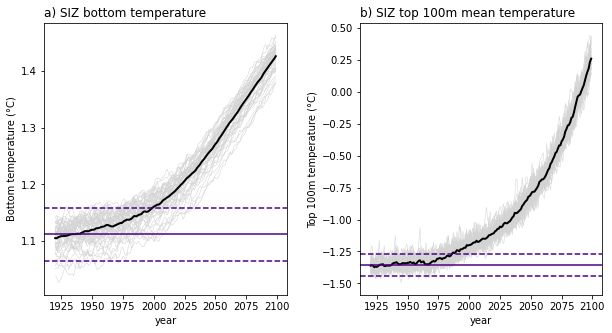

In [23]:
fig = plt.figure(figsize=(10,5))

######################################################

ax = fig.add_subplot(1,2,1)

ax.set_title('a) SIZ bottom temperature',loc='left')

for mem in np.arange(0,50,1):
    ax.plot(years, ts_siz['TEMP_bottom'].isel(member_id=mem), color='lightgray', linewidth=0.5)
    
## plot means

ax.plot(years, ts_siz['TEMP_bottom'].mean(dim='member_id'), color='black', linewidth=2)

mean = ts_siz['TEMP_bottom'].isel(time=slice(0,30)).mean(dim=('time','member_id')).values
std = ts_siz['TEMP_bottom'].isel(time=slice(0,30)).std(dim=('time','member_id')).values
ax.axhline(mean, color='indigo')
ax.axhline(mean+2*std, color='indigo',linestyle='--')
ax.axhline(mean-2*std, color='indigo',linestyle='--')

ax.set(xlabel='year',ylabel='Bottom temperature (°C)');
#ax.set_ylim(0,1.6)



####################################
ax = fig.add_subplot(1,2,2)

ax.set_title('b) SIZ top 100m mean temperature',loc='left')

for mem in np.arange(0,50,1):
    ax.plot(years, ts_siz['TEMP_100m'].isel(member_id=mem), color='lightgray', linewidth=0.5)
    
## plot means

ax.plot(years, ts_siz['TEMP_100m'].mean(dim='member_id'), color='black', linewidth=2)

mean = ts_siz['TEMP_100m'].isel(time=slice(0,30)).mean(dim=('time','member_id')).values
std = ts_siz['TEMP_100m'].isel(time=slice(0,30)).std(dim=('time','member_id')).values
ax.axhline(mean, color='indigo')
ax.axhline(mean+2*std, color='indigo',linestyle='--')
ax.axhline(mean-2*std, color='indigo',linestyle='--')

ax.set(xlabel='year',ylabel='Top 100m temperature (°C)');
#ax.set_ylim(0,1.6)

fig.subplots_adjust(wspace=0.3)

In [24]:
mean = ts_siz['TEMP_100m'].isel(time=slice(0,30)).mean(dim=('time','member_id')).values
std = ts_siz['TEMP_100m'].isel(time=slice(0,30)).std(dim=('time','member_id')).values
toe_temp100m = ts_siz['TEMP_100m']['time'].where(ts_siz['TEMP_100m'].mean(dim='member_id') > mean+2*std).min(dim='time')
toe_temp100m_val = mean+2*std
print(toe_temp100m,toe_temp100m_val)

<xarray.DataArray 'time' ()>
array(1986.) -1.268038557529306


In [25]:
mean = ts_siz['TEMP_bottom'].isel(time=slice(0,30)).mean(dim=('time','member_id')).values
std = ts_siz['TEMP_bottom'].isel(time=slice(0,30)).std(dim=('time','member_id')).values
toe_temp_bot = ts_siz['TEMP_bottom']['time'].where(ts_siz['TEMP_bottom'].mean(dim='member_id') > mean+2*std).min(dim='time')
toe_temp_bot_val = mean+2*std
print(toe_temp_bot,toe_temp_bot_val)

<xarray.DataArray 'time' ()>
array(1999.) 1.158422038787581


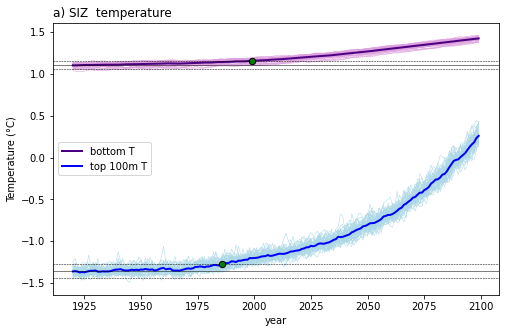

In [26]:
fig = plt.figure(figsize=(8,5))

######################################################

ax = fig.add_subplot(1,1,1)

ax.set_title('a) SIZ  temperature',loc='left')

for mem in np.arange(0,50,1):
    ax.plot(years, ts_siz['TEMP_bottom'].isel(member_id=mem), color='plum', linewidth=0.5)
    
## plot means

ax.plot(years, ts_siz['TEMP_bottom'].mean(dim='member_id'), color='indigo', linewidth=2, label='bottom T')

mean = ts_siz['TEMP_bottom'].isel(time=slice(0,30)).mean(dim=('time','member_id')).values
std = ts_siz['TEMP_bottom'].isel(time=slice(0,30)).std(dim=('time','member_id')).values
ax.axhline(mean, color='black', linewidth=0.5)
ax.axhline(mean+2*std, color='black',linestyle='--', linewidth=0.5)
ax.axhline(mean-2*std, color='black',linestyle='--', linewidth=0.5)
ax.set(xlabel='year',ylabel='Temperature (°C)');
ax.scatter(toe_temp_bot,toe_temp_bot_val,s=40,color='green',edgecolor='black',zorder=3)
#ax.set_ylim(0,1.6)
############## 100m temp
for mem in np.arange(0,50,1):
    ax.plot(years, ts_siz['TEMP_100m'].isel(member_id=mem), color='lightblue', linewidth=0.5)
    
## plot means

ax.plot(years, ts_siz['TEMP_100m'].mean(dim='member_id'), color='blue', linewidth=2, label='top 100m T')

mean = ts_siz['TEMP_100m'].isel(time=slice(0,30)).mean(dim=('time','member_id')).values
std = ts_siz['TEMP_100m'].isel(time=slice(0,30)).std(dim=('time','member_id')).values
ax.axhline(mean, color='black', linewidth=0.5)
ax.axhline(mean+2*std, color='black',linestyle='--', linewidth=0.5)
ax.axhline(mean-2*std, color='black',linestyle='--', linewidth=0.5)
ax.scatter(toe_temp100m,toe_temp100m_val,s=40,color='green',edgecolor='black',zorder=3)

ax.legend()

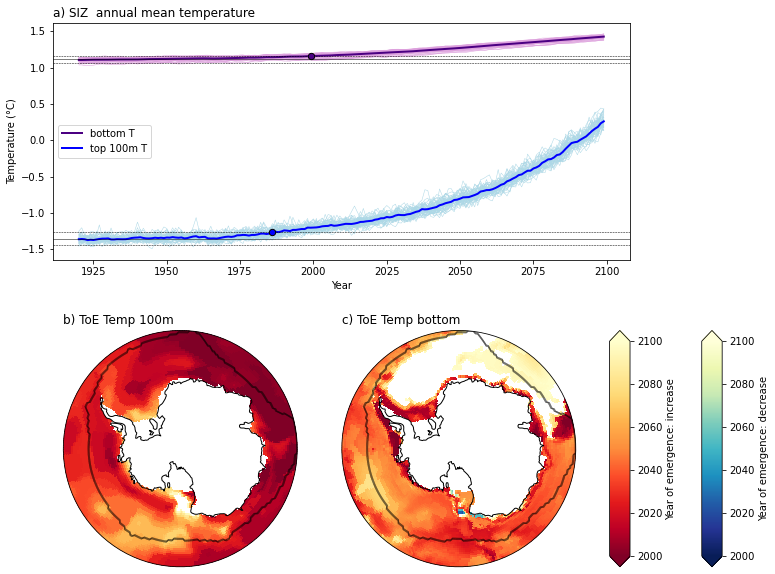

In [27]:
fig = plt.figure(figsize=(12, 10))
gs = gridspec.GridSpec(nrows=2, ncols=5, width_ratios=(1, 1, 0.08, 0.1, 0.08),height_ratios=(1,1))

prj =ccrs.SouthPolarStereo()

ax_lines = plt.subplot(gs[0, 0:3])
ax_map1 = plt.subplot(gs[1, 0], projection=prj)
ax_map2 = plt.subplot(gs[1, 1], projection=prj)

ax_cb1 = plt.subplot(gs[1, 2])
ax_cb2 = plt.subplot(gs[1, 4])
################# line plot
ax_lines.set_title('a) SIZ  annual mean temperature',loc='left')

for mem in np.arange(0,50,1):
    ax_lines.plot(years, ts_siz['TEMP_bottom'].isel(member_id=mem), color='plum', linewidth=0.5)
ax_lines.plot(years, ts_siz['TEMP_bottom'].mean(dim='member_id'), color='indigo', linewidth=2, label='bottom T')
mean = ts_siz['TEMP_bottom'].isel(time=slice(0,30)).mean(dim=('time','member_id')).values
std = ts_siz['TEMP_bottom'].isel(time=slice(0,30)).std(dim=('time','member_id')).values
ax_lines.axhline(mean, color='black', linewidth=0.5)
ax_lines.axhline(mean+2*std, color='black',linestyle='--', linewidth=0.5)
ax_lines.axhline(mean-2*std, color='black',linestyle='--', linewidth=0.5)
ax_lines.scatter(toe_temp_bot,toe_temp_bot_val,s=40,color='indigo',edgecolor='black',zorder=3)
ax_lines.set(xlabel='Year',ylabel='Temperature (°C)');
for mem in np.arange(0,50,1):
    ax_lines.plot(years, ts_siz['TEMP_100m'].isel(member_id=mem), color='lightblue', linewidth=0.5)
ax_lines.plot(years, ts_siz['TEMP_100m'].mean(dim='member_id'), color='blue', linewidth=2, label='top 100m T')
mean = ts_siz['TEMP_100m'].isel(time=slice(0,30)).mean(dim=('time','member_id')).values
std = ts_siz['TEMP_100m'].isel(time=slice(0,30)).std(dim=('time','member_id')).values
ax_lines.axhline(mean, color='black', linewidth=0.5)
ax_lines.axhline(mean+2*std, color='black',linestyle='--', linewidth=0.5)
ax_lines.axhline(mean-2*std, color='black',linestyle='--', linewidth=0.5)
ax_lines.scatter(toe_temp100m,toe_temp100m_val,s=40,color='blue',edgecolor='black',zorder=3)
ax_lines.legend()

############## ToE maps

ax_map1.set_extent([-180, 180, -90, -57], ccrs.PlateCarree())
ax_map1.set_title('b) ToE Temp 100m', loc='left')
plt.rcParams['hatch.color'] = 'lightgray'
siz = ds_siz_mask.SIZ.where(ds_siz_mask.SIZ==1,other=0).where(ds_grid.REGION_MASK>0)
lon, lat, field = utils.adjust_pop_grid(lons, lats, siz)
pci = ax_map1.contour(lon, lat, field,transform=ccrs.PlateCarree(),linewidths=0.2,colors='black')
lon,lat,field = utils.adjust_pop_grid(lons, lats, ToE_up_TEMP_100m)
pc1 = ax_map1.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                   cmap='YlOrRd_r',
                   vmin=2000,vmax=2100
                  )
lon,lat,field = utils.adjust_pop_grid(lons, lats, ToE_down_TEMP_100m)
pc2 = ax_map1.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                   cmap='YlGnBu_r',
                   vmin=2000,vmax=2100
                  )
ax_map1.set_boundary(circle, transform=ax_map1.transAxes)
ax_map1.coastlines('110m',linewidth=1)


ax_map2.set_extent([-180, 180, -90, -57], ccrs.PlateCarree())
ax_map2.set_title('c) ToE Temp bottom', loc='left')
plt.rcParams['hatch.color'] = 'lightgray'
siz = ds_siz_mask.SIZ.where(ds_siz_mask.SIZ==1,other=0).where(ds_grid.REGION_MASK>0)
lon, lat, field = utils.adjust_pop_grid(lons, lats, siz)
pci = ax_map2.contour(lon, lat, field,transform=ccrs.PlateCarree(),linewidths=0.2,colors='black')
lon,lat,field = utils.adjust_pop_grid(lons, lats, ToE_up_TEMP_bottom)
pc1 = ax_map2.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                   cmap='YlOrRd_r',
                   vmin=2000,vmax=2100
                  )
lon,lat,field = utils.adjust_pop_grid(lons, lats, ToE_down_TEMP_bottom)
pc2 = ax_map2.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                   cmap='YlGnBu_r',
                   vmin=2000,vmax=2100
                  )
ax_map2.set_boundary(circle, transform=ax_map2.transAxes)
ax_map2.coastlines('110m',linewidth=1)

############ cb
cbar1 = fig.colorbar(pc1, cax=ax_cb1,extend='both',label='Year of emergence: increase')

cbar1 = fig.colorbar(pc2, cax=ax_cb2,extend='both',label='Year of emergence: decrease')

fig.subplots_adjust(hspace=0.3)

fig.savefig('/glade/work/kristenk/figs/FigS5_temperatureToE.png', bbox_inches='tight', dpi=300, format='png');

### Now plot mesozoo biomass and POC flux to floor

In [28]:
%%time
files = sorted(glob(f'/glade/campaign/cesm/development/bgcwg/projects/CESM2-LE-FEISTY/drivers/mesozooC_zint_100m/CESM2-LE_HIST_SSP370_mesozooC_zint_100m_????????.nc'))       
ds = xr.open_mfdataset(files, concat_dim="member_id", combine='nested',preprocess=preprocess).compute()

CPU times: user 11.6 s, sys: 35.7 s, total: 47.3 s
Wall time: 3min 35s


In [29]:
%%time
files = sorted(glob(f'/glade/campaign/cesm/development/bgcwg/projects/CESM2-LE-FEISTY/drivers/POC_FLUX_bottom/CESM2-LE_HIST_SSP370_pocToFloor_????????.nc'))       
ds_tmp = xr.open_mfdataset(files, concat_dim="member_id", combine='nested',preprocess=preprocess).compute()

CPU times: user 5.18 s, sys: 7.59 s, total: 12.8 s
Wall time: 1min 20s


In [30]:
#ds['pocToFloor'] = ds_tmp.pocToFloor

In [31]:
%%time

ds = ds.resample({'time':'A'}, keep_attrs=True).mean(dim='time', keep_attrs=True).compute()
ds_tmp = ds_tmp.resample({'time':'A'}, keep_attrs=True).mean(dim='time', keep_attrs=True).compute()

CPU times: user 24.7 s, sys: 30.2 s, total: 54.9 s
Wall time: 3min 28s


In [32]:
ds['time'] = np.arange(1850,2101,1)
ds_tmp['time'] = np.arange(1850,2101,1)

In [33]:
ds = ds.isel(time=slice(70,250))
ds_tmp = ds_tmp.isel(time=slice(70,250))

In [34]:
ds['mesozooC_zint_100m'] = ds.mesozooC_zint_100m.where(ds.mesozooC_zint_100m > 0.001).where(ds.mesozooC_zint_100m < 10000)

In [35]:
%%time

# #### empty dictionaries, keys are variable names
upthres_ds = xr.Dataset()
lothres_ds = xr.Dataset()

variables=['pocToFloor'] #,'mesozooC_zint_100m']

for var in variables:
    
    ### calculate                                                                                                                                                                                                                                                                 
    mean_var = ds_tmp[var].isel(time=slice(0,30)).mean(dim=('time','member_id'))
    std_var = ds_tmp[var].isel(time=slice(0,30)).std(dim=('member_id','time'))
    
    var_array_upthres = mean_var + 2 * std_var
    var_array_lothres = mean_var - 2 * std_var

    upthres_ds[var] = var_array_upthres
    lothres_ds[var] = var_array_lothres

CPU times: user 96 ms, sys: 19.7 ms, total: 116 ms
Wall time: 130 ms


In [36]:
%%time

# #### empty dictionaries, keys are variable names
# upthres_ds = xr.Dataset()
# lothres_ds = xr.Dataset()

variables=['mesozooC_zint_100m']

for var in variables:
    
    ### calculate                                                                                                                                                                                                                                                                 
    mean_var = ds[var].isel(time=slice(0,30)).mean(dim=('time','member_id'))
    std_var = ds[var].isel(time=slice(0,30)).std(dim=('member_id','time'))
    
    var_array_upthres = mean_var + 2 * std_var
    var_array_lothres = mean_var - 2 * std_var

    upthres_ds[var] = var_array_upthres
    lothres_ds[var] = var_array_lothres

CPU times: user 145 ms, sys: 12.6 ms, total: 158 ms
Wall time: 246 ms


In [37]:
ToE_down_POCfloor = time3d.where(ds_tmp.pocToFloor.mean(dim='member_id') < lothres_ds['pocToFloor'])
ToE_down_POCfloor = ToE_down_POCfloor.min(dim='time')

ToE_down_mesozooC = time3d.where(ds.mesozooC_zint_100m.mean(dim='member_id') < lothres_ds['mesozooC_zint_100m'])
ToE_down_mesozooC = ToE_down_mesozooC.min(dim='time')

In [38]:
ToE_up_POCfloor = time3d.where(ds_tmp.pocToFloor.mean(dim='member_id') > upthres_ds['pocToFloor'])
ToE_up_POCfloor = ToE_up_POCfloor.min(dim='time')

ToE_up_mesozooC = time3d.where(ds.mesozooC_zint_100m.mean(dim='member_id') > upthres_ds['mesozooC_zint_100m'])
ToE_up_mesozooC = ToE_up_mesozooC.min(dim='time')

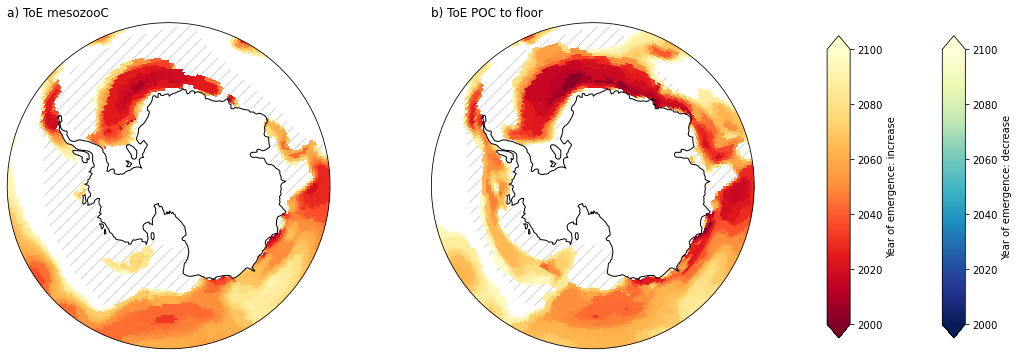

In [39]:
fig = plt.figure(figsize=(16,6))

#########################################################
ax = fig.add_subplot(1,2,1, projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -57], ccrs.PlateCarree())
ax.set_title('a) ToE mesozooC', loc='left')

### add hatch lines for the SIZ
plt.rcParams['hatch.color'] = 'lightgray'
lon, lat, field = utils.adjust_pop_grid(lons, lats, ds_siz_mask.SIZ)
pci=ax.contourf(lon, lat, field,transform=ccrs.PlateCarree(),hatches=['//'],colors='none')


lon,lat,field = utils.adjust_pop_grid(lons, lats, ToE_up_mesozooC)

pc1 = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                   cmap='YlOrRd_r',
                   vmin=2000,vmax=2100
                  )

lon,lat,field = utils.adjust_pop_grid(lons, lats, ToE_down_mesozooC)

pc2 = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                   cmap='YlGnBu_r',
                   vmin=2000,vmax=2100
                  )
ax.set_boundary(circle, transform=ax.transAxes)

ax.coastlines('110m',linewidth=1)

######## ToE NPP increase #################################################
ax = fig.add_subplot(1,2,2, projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -57], ccrs.PlateCarree())
ax.set_title('b) ToE POC to floor', loc='left')

### add hatch lines for the SIZ
plt.rcParams['hatch.color'] = 'lightgray'
lon, lat, field = utils.adjust_pop_grid(lons, lats, ds_siz_mask.SIZ)
pci=ax.contourf(lon, lat, field,transform=ccrs.PlateCarree(),hatches=['//'],colors='none')

lon,lat,field = utils.adjust_pop_grid(lons, lats, ToE_up_POCfloor)

pc1 = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                   cmap='YlOrRd_r',
                   vmin=2000,vmax=2100
                  )

lon,lat,field = utils.adjust_pop_grid(lons, lats, ToE_down_POCfloor)

pc2 = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                   cmap='YlGnBu_r',
                   vmin=2000,vmax=2100
                  )

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

ax.coastlines('110m',linewidth=1)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar1 = fig.colorbar(pc1, cax=cbar_ax,extend='both',label='Year of emergence: increase')


cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
cbar1 = fig.colorbar(pc2, cax=cbar_ax,extend='both',label='Year of emergence: decrease')
#fig.savefig('/glade/work/kristenk/figs/fig_TOE_Krill_growth_pot.png', bbox_inches='tight', dpi=300, format='png');

In [40]:
for v in ['mesozooC_zint_100m']:


    masked_area = area.where(ds_siz_mask['SIZ']==1)
    
    masked_var = ds[v].where(ds_siz_mask['SIZ']==1)
    masked_area['nlat'] = ds_siz_mask['SIZ'].nlat
    masked_area['nlon'] = ds_siz_mask['SIZ'].nlon
    
    ts_siz[v] = (masked_var * masked_area).sum(dim=('nlon','nlat')) / masked_area.sum(dim=('nlon','nlat'))
        

In [41]:
ts_siz2 = xr.Dataset() #making new ts because there won't be the number of ens mems

for v in ['pocToFloor']:


    masked_area = area.where(ds_siz_mask['SIZ']==1)
    
    masked_var = ds_tmp[v].where(ds_siz_mask['SIZ']==1)
    masked_area['nlat'] = ds_siz_mask['SIZ'].nlat
    masked_area['nlon'] = ds_siz_mask['SIZ'].nlon
    
    ts_siz2[v] = (masked_var * masked_area).sum(dim=('nlon','nlat')) / masked_area.sum(dim=('nlon','nlat'))
        

In [42]:
### the units for mesozooC_zint are mmol/m3 cm so to get to mmol/m2 multiply by 0.01

In [43]:
mean = ts_siz2['pocToFloor'].isel(time=slice(0,30)).mean(dim=('time','member_id')).values
std = ts_siz2['pocToFloor'].isel(time=slice(0,30)).std(dim=('time','member_id')).values
toe_poc2floor = ts_siz2['pocToFloor']['time'].where(ts_siz2['pocToFloor'].mean(dim='member_id') > mean+2*std).min(dim='time')
toe_poc2floor_val = mean+2*std
print(toe_poc2floor,toe_poc2floor_val)

<xarray.DataArray 'time' ()>
array(2014.) 0.00016886567868653208


In [44]:
mean = ts_siz['mesozooC_zint_100m'].isel(time=slice(0,30)).mean(dim=('time','member_id')).values
std = ts_siz['mesozooC_zint_100m'].isel(time=slice(0,30)).std(dim=('time','member_id')).values
toe_mesozooC = ts_siz['mesozooC_zint_100m']['time'].where(ts_siz['mesozooC_zint_100m'].mean(dim='member_id') > mean+2*std).min(dim='time')
toe_mesozooC_val = mean+2*std
print(toe_mesozooC,toe_mesozooC_val)

<xarray.DataArray 'time' ()>
array(2012.) 1343.7696304897297


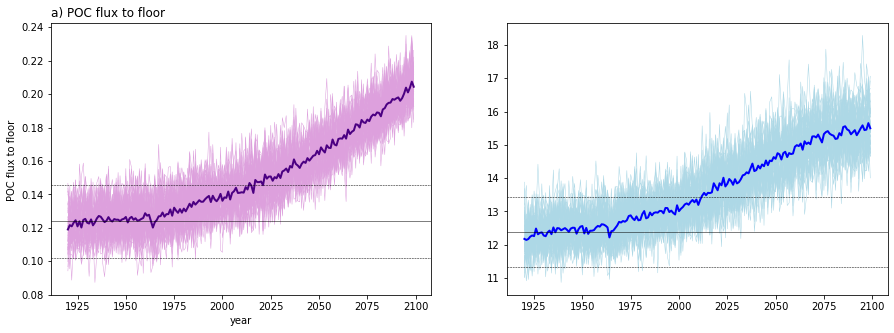

In [45]:
fig = plt.figure(figsize=(15,5))

convert = 0.01 * 86400

######################################################

ax = fig.add_subplot(1,2,1)

ax.set_title('a) POC flux to floor',loc='left')

for mem in np.arange(0,48,1):
    ax.plot(years, ts_siz2['pocToFloor'].isel(member_id=mem)*convert, color='plum', linewidth=0.5)
    
## plot means

ax.plot(years, ts_siz2['pocToFloor'].mean(dim='member_id')*convert, color='indigo', linewidth=2, label='POC to ocean floor')

mean = ts_siz2['pocToFloor'].isel(time=slice(0,30)).mean(dim=('time','member_id')).values*convert
std = ts_siz2['pocToFloor'].isel(time=slice(0,30)).std(dim=('time','member_id')).values*convert
ax.axhline(mean, color='black', linewidth=0.5)
ax.axhline(mean+2*std, color='black',linestyle='--', linewidth=0.5)
ax.axhline(mean-2*std, color='black',linestyle='--', linewidth=0.5)
ax.set(xlabel='year',ylabel='POC flux to floor ');
#ax.scatter(toe_temp_bot,toe_temp_bot_val,s=40,color='green',edgecolor='black',zorder=3)


ax = fig.add_subplot(1,2,2)
############## 100m temp
for mem in np.arange(0,50,1):
    ax.plot(years, ts_siz['mesozooC_zint_100m'].isel(member_id=mem)*0.01, color='lightblue', linewidth=0.5)
    
## plot means

ax.plot(years, ts_siz['mesozooC_zint_100m'].mean(dim='member_id')*0.01, color='blue', linewidth=2, label='Mesozoo biomass')

mean = ts_siz['mesozooC_zint_100m'].isel(time=slice(0,30)).mean(dim=('time','member_id')).values*0.01
std = ts_siz['mesozooC_zint_100m'].isel(time=slice(0,30)).std(dim=('time','member_id')).values*0.01
ax.axhline(mean, color='black', linewidth=0.5)
ax.axhline(mean+2*std, color='black',linestyle='--', linewidth=0.5)
ax.axhline(mean-2*std, color='black',linestyle='--', linewidth=0.5)

# ax.legend()

In [46]:
# for member in np.arange(0,48):

#     print(member, min(ts_siz2.pocToFloor.isel(member_id=member).values))

In [47]:
######## so ensemble members at locs 5 and 47 seem to have the problem
#files[5]
#files[46]

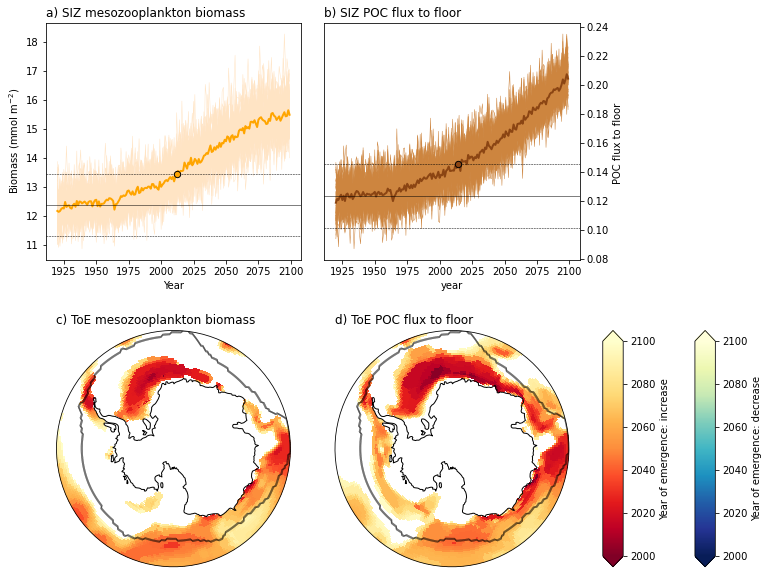

In [48]:
fig = plt.figure(figsize=(12, 10))
gs = gridspec.GridSpec(nrows=2, ncols=5, width_ratios=(1, 1, 0.08, 0.1, 0.08),height_ratios=(1,1))

prj =ccrs.SouthPolarStereo()

ax_lines1 = plt.subplot(gs[0, 0])
ax_lines2 = plt.subplot(gs[0, 1])

ax_map1 = plt.subplot(gs[1, 0], projection=prj)
ax_map2 = plt.subplot(gs[1, 1], projection=prj)

ax_cb1 = plt.subplot(gs[1, 2])
ax_cb2 = plt.subplot(gs[1, 4])

convert = 0.01 * 86400


################# line plots
ax_lines1.set_title('a) SIZ mesozooplankton biomass',loc='left')

for mem in np.arange(0,50,1):
    ax_lines1.plot(years, ts_siz['mesozooC_zint_100m'].isel(member_id=mem)*0.01, color='bisque', linewidth=0.5)
ax_lines1.plot(years, ts_siz['mesozooC_zint_100m'].mean(dim='member_id')*0.01, color='orange', linewidth=2, label='bottom T')
mean = ts_siz['mesozooC_zint_100m'].isel(time=slice(0,30)).mean(dim=('time','member_id')).values*0.01
std = ts_siz['mesozooC_zint_100m'].isel(time=slice(0,30)).std(dim=('time','member_id')).values*0.01
ax_lines1.axhline(mean, color='black', linewidth=0.5)
ax_lines1.axhline(mean+2*std, color='black',linestyle='--', linewidth=0.5)
ax_lines1.axhline(mean-2*std, color='black',linestyle='--', linewidth=0.5)
ax_lines1.scatter(toe_mesozooC,toe_mesozooC_val*0.01,s=40,color='orange',edgecolor='black',zorder=3)
ax_lines1.set(xlabel='Year',ylabel='Biomass (mmol m$^{-2}$)');




ax_lines2.set_title('b) SIZ POC flux to floor',loc='left')

for mem in np.arange(0,48,1):
    ax_lines2.plot(years, ts_siz2['pocToFloor'].isel(member_id=mem)*convert, color='peru', linewidth=0.5)
ax_lines2.plot(years, ts_siz2['pocToFloor'].mean(dim='member_id')*convert, color='saddlebrown', linewidth=2, label='POC to ocean floor')
mean = ts_siz2['pocToFloor'].isel(time=slice(0,30)).mean(dim=('time','member_id')).values*convert
std = ts_siz2['pocToFloor'].isel(time=slice(0,30)).std(dim=('time','member_id')).values*convert
ax_lines2.axhline(mean, color='black', linewidth=0.5)
ax_lines2.axhline(mean+2*std, color='black',linestyle='--', linewidth=0.5)
ax_lines2.axhline(mean-2*std, color='black',linestyle='--', linewidth=0.5)
ax_lines2.set(xlabel='year',ylabel='POC flux to floor ');
ax_lines2.scatter(toe_poc2floor,toe_poc2floor_val*convert,s=40,color='saddlebrown',edgecolor='black',zorder=3)

ax_lines2.tick_params(top=False, labeltop=False,
bottom=True, labelbottom=True,
right=True, labelright=True,
left=False, labelleft=False)
#ax_lines2.spines[['left','top']].set_visible(False);
ax_lines2.yaxis.set_label_position("right")

############## ToE maps

ax_map1.set_extent([-180, 180, -90, -57], ccrs.PlateCarree())
ax_map1.set_title('c) ToE mesozooplankton biomass', loc='left')
plt.rcParams['hatch.color'] = 'lightgray'
siz = ds_siz_mask.SIZ.where(ds_siz_mask.SIZ==1,other=0).where(ds_grid.REGION_MASK>0)
lon, lat, field = utils.adjust_pop_grid(lons, lats, siz)
pci = ax_map1.contour(lon, lat, field,transform=ccrs.PlateCarree(),linewidths=0.2,colors='black')
lon,lat,field = utils.adjust_pop_grid(lons, lats, ToE_up_mesozooC)
pc1 = ax_map1.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                   cmap='YlOrRd_r',
                   vmin=2000,vmax=2100
                  )
lon,lat,field = utils.adjust_pop_grid(lons, lats, ToE_down_mesozooC)
pc2 = ax_map1.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                   cmap='YlGnBu_r',
                   vmin=2000,vmax=2100
                  )
ax_map1.set_boundary(circle, transform=ax_map1.transAxes)
ax_map1.coastlines('110m',linewidth=1)


ax_map2.set_extent([-180, 180, -90, -57], ccrs.PlateCarree())
ax_map2.set_title('d) ToE POC flux to floor', loc='left')
plt.rcParams['hatch.color'] = 'lightgray'
siz = ds_siz_mask.SIZ.where(ds_siz_mask.SIZ==1,other=0).where(ds_grid.REGION_MASK>0)
lon, lat, field = utils.adjust_pop_grid(lons, lats, siz)
pci = ax_map2.contour(lon, lat, field,transform=ccrs.PlateCarree(),linewidths=0.2,colors='black')
lon,lat,field = utils.adjust_pop_grid(lons, lats, ToE_up_POCfloor)
pc1 = ax_map2.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                   cmap='YlOrRd_r',
                   vmin=2000,vmax=2100
                  )
lon,lat,field = utils.adjust_pop_grid(lons, lats, ToE_down_POCfloor)
pc2 = ax_map2.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                   cmap='YlGnBu_r',
                   vmin=2000,vmax=2100
                  )
ax_map2.set_boundary(circle, transform=ax_map2.transAxes)
ax_map2.coastlines('110m',linewidth=1)

############ cb
cbar1 = fig.colorbar(pc1, cax=ax_cb1,extend='both',label='Year of emergence: increase')

cbar1 = fig.colorbar(pc2, cax=ax_cb2,extend='both',label='Year of emergence: decrease')

fig.subplots_adjust(hspace=0.3)

fig.savefig('/glade/work/kristenk/figs/FigS6_Mesozoo_POC2floor_ToE.png', bbox_inches='tight', dpi=300, format='png');